In [44]:
import argparse
import json
import gzip
import os
import urllib.request
import networkx as nx
from bz2 import BZ2File as bzopen
from urllib.request import urlopen
from networkx.readwrite import json_graph
from bs4 import BeautifulSoup
import datetime
from dateutil.relativedelta import *
import random
import shutil
from collections import defaultdict 
import numpy as np

def update_graph(year, month, G):
    # Update graph from AS relationships data
    data_dir = 'as_relationships_data'
    fname = os.path.join(data_dir, f'{year}{month}01.as-rel.txt.bz2')
    with bzopen(fname, 'r') as f:
        for i, line in enumerate(f):
            line = line.decode('utf-8').strip()
            if line.startswith('#'):
                continue
            else:
                l = line.split('|')
                as1 = int(l[0])
                as2 = int(l[1])
                relationship_type = int(l[2])
                if relationship_type == -1:
                    r = 'c2p'
                elif relationship_type == 0:
                    r = 'p2p'
                else:
                    raise Exception('Invalid relationship type!')
                if (as1, as2) not in G.edges:
                    G.add_edge(as1, as2, label=r, timestamp=datetime.date(year=int(year), month=int(month), day=1))
    return G


def download_as_links_files(year, month, monitor=None):
    url = f'http://data.caida.org/datasets/topology/ark/ipv6/as-links/{year}/{month}'
    html = urlopen(url)
    soup = BeautifulSoup(html, 'html.parser')
    links = []
    for link in soup.find_all('a'):
        l = link.get('href')
        if l.startswith('cycle-aslinks.l8') and year + month in l:
            lsplit = l.split('.')
            m = lsplit[-3]
            if (monitor is not None and monitor == m) or monitor is None:
                links.append(l)
    data_dir = 'as_links_data'
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    out_dir = os.path.join(data_dir, year + month)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    for l in links:
        full_link = os.path.join(url, l)
        out_file = os.path.join(out_dir, l)
        if os.path.exists(out_file):
            continue
        else:
            print(f'Downloading {full_link} to {out_file}')
            urllib.request.urlretrieve(full_link, out_file)


def download_as_relationships_file(year, month):
    l = f'{year}{month}01.as-rel.txt.bz2'
    full_link = f'http://data.caida.org/datasets/as-relationships/serial-1/{l}'
    data_dir = 'as_relationships_data'
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    out_file = os.path.join(data_dir, l)
    if not os.path.exists(out_file):
        print(f'Downloading {full_link} to {out_file}')
        urllib.request.urlretrieve(full_link, out_file)

        
def remove_files_(year, month):
    data_dir = 'as_links_data'
    out_dir = os.path.join(data_dir, year + month)
    print(f'Removing {out_dir}')
    shutil.rmtree(out_dir)
    data_dir = 'as_relationships_data'
    l = f'{year}{month}01.as-rel.txt.bz2'
    out_file = os.path.join(data_dir, l)
    print(f'Removing {out_file}')
    os.remove(out_file)
    

In [2]:
start_date = datetime.date(year=2018, month=12, day=1)
end_date = datetime.date(year=2019, month=1, day=1)

# monitor = 'sea-us'
# monitors = ['sea-us']
monitor = None

In [3]:
def process_as(as1, G, fname, initial=False):
    timestamp = int(fname.split('.')[3])
    if as1 not in G.nodes:
        return
#         G.add_node(as1)
    G.nodes[as1]['ipv6'] = True
    if initial:
        # Node is initially IPv6
        G.nodes[as1]['time_adopted'] = 0
        return
    else:
        # Node adopted IPv6 at this timestamp
        G.nodes[as1]['time_adopted'] = timestamp

    # Get num neighbors that have adopted IPv6
    ipv6_neighbors = 0
    for n in G.neighbors(as1):
        if G.nodes[n].get('ipv6'):
            ipv6_neighbors += 1

    G.nodes[as1]['ipv6_neighbors'] = ipv6_neighbors
    num_neighbors = len(list(G.neighbors(as1)))
    G.nodes[as1]['num_neighbors'] = num_neighbors

In [4]:
def run_analysis(start_date, end_date, m, remove_files=True):
    # Create graph from AS relationships
    G = nx.Graph()

    cur_date = start_date
    initial = True
    ipv6_nodes = set() # Set of all nodes that have adopted IPv6

    while cur_date < end_date:
        cur_month = cur_date.strftime('%m')
        cur_year = cur_date.strftime('%Y')
        print(f'{cur_month}/{cur_year}')

        download_as_links_files(cur_year, cur_month, m)
        download_as_relationships_file(cur_year, cur_month)

        G = update_graph(cur_year, cur_month, G)
        print(f'G # nodes: {len(G.nodes)}')
        print(f'G # edges: {len(G.edges)}')

        folder = os.path.join('as_links_data', cur_year + cur_month)
        fnames = sorted(os.listdir(folder))

        for fname in fnames:
            if not fname.endswith('.gz'):
                continue
            if m is not None and m not in fname:
                continue
            with gzip.open(os.path.join(folder, fname), 'r') as f:
                for i, line in enumerate(f):
                    line = line.decode('utf-8').strip()
                    if line.startswith('D') or line.startswith('I'):
                        line = line.split('\t')
                        type_ = line[0]
                        as1_list = line[1].split(',')
                        as2_list = line[2].split(',')
                        for as1 in as1_list:
                            as1 = int(as1)
                            if as1 not in ipv6_nodes: # Newly adopted IPv6
                                ipv6_nodes.add(as1)
                                process_as(as1, G, fname, initial)
                            for as2 in as2_list:
                                as2 = int(as2)
                                if as2 not in ipv6_nodes: # Newly adopted IPv6
                                    ipv6_nodes.add(as2)
                                    process_as(as2, G, fname, initial)
    #                             if (as1, as2) not in G.edges:
    #                                 print(as1, as2)
    #                                 G.add_edge(as1, as2)
            initial = False

        print(len(ipv6_nodes))
        cur_date += relativedelta(months=+1)
        
        if remove_files:
            remove_files_(cur_year, cur_month)
    return G

In [5]:
G = run_analysis(start_date, end_date, monitor, remove_files=False)

12/2018
G # nodes: 63361
G # edges: 320978
10296


In [158]:
initial_ipv6 = [i for i in G.nodes if G.nodes[i].get('time_adopted') == 0]
print(len(initial_ipv6))
ipv6_nodes = [n for n in G.nodes if G.nodes[n].get('ipv6')]
print(len(ipv6_nodes))

8041
9880


In [161]:
def calculate_cascade_size(node, seen_nodes):
    time_adopted = G.nodes[node]['time_adopted']
    cascade_size = 1
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor].get('ipv6') and G.nodes[neighbor]['time_adopted'] > time_adopted and neighbor not in seen_nodes:
#             print(node, time_adopted, neighbor, G.nodes[neighbor]['time_adopted'])
            seen_nodes.add(node)
            cascade_size += calculate_cascade_size(neighbor, seen_nodes)
    return cascade_size

def calculate_cascade_depth(node, depth, seen_nodes):
    time_adopted = G.nodes[node]['time_adopted']
#     print('node', node)
#     print('depth', depth)
    max_depth = 0
    max_neighbor = 0
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor].get('ipv6') and G.nodes[neighbor]['time_adopted'] > time_adopted and neighbor not in seen_nodes:
#             print('influence', neighbor)
            seen_nodes.add(neighbor)
            neighbor_depth = calculate_cascade_depth(neighbor, depth + 1, seen_nodes)
#             print(neighbor_depth, max_depth)
            if neighbor_depth > max_depth:
                max_depth = neighbor_depth
                max_neighbor = neighbor
    return max_depth + 1

def calculate_num_ipv6_influencers(node):
    num_ipv6 = 0
    time_adopted = G.nodes[node]['time_adopted']
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor].get('ipv6') and G.nodes[neighbor]['time_adopted'] < time_adopted:
            num_ipv6 += 1
    return num_ipv6

def calculate_frac_ipv6_influencers(node):
    num_ipv6 = 0
    total = 0
    time_adopted = G.nodes[node]['time_adopted']
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor].get('ipv6') and G.nodes[neighbor]['time_adopted'] < time_adopted:
            num_ipv6 += 1
        total += 1
    if total == 0:
        return 0
    return num_ipv6 / float(total)

def build_graph(node, seen_nodes, c_G, labels):
    time_adopted = G.nodes[node]['time_adopted']
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor].get('ipv6') and G.nodes[neighbor]['time_adopted'] > time_adopted:
            c_G.add_edge(node, neighbor)
            labels[neighbor] = datetime.datetime.utcfromtimestamp(G.nodes[neighbor]['time_adopted']).strftime('%Y-%m-%d %H:%M:%S')
            if neighbor not in seen_nodes:
                seen_nodes.add(neighbor)
                c_G, labels = build_graph(neighbor, seen_nodes, c_G, labels)
    return c_G, labels





(array([1.717e+03, 9.200e+01, 1.700e+01, 1.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([   0.        ,   45.06666667,   90.13333333,  135.2       ,
         180.26666667,  225.33333333,  270.4       ,  315.46666667,
         360.53333333,  405.6       ,  450.66666667,  495.73333333,
         540.8       ,  585.86666667,  630.93333333,  676.        ,
         721.06666667,  766.13333333,  811.2       ,  856.26666667,
         901.33333333,  946.4       ,  991.46666667, 1036.53333333,
        1081.6       , 1126.66666667, 1171.73333333, 1216.8       ,
        1261.86666667, 1306.93333333, 1352.        ]),
 <a list of 30 Patch objects>)

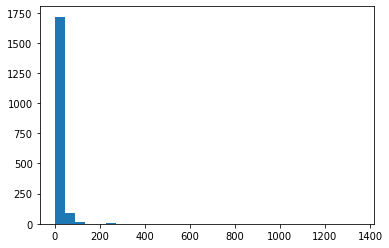

In [163]:
num_ipv6_influencers = [calculate_num_ipv6_influencers(node) for node in set(ipv6_nodes) - set(initial_ipv6)]
frac_ipv6_influencers = [calculate_frac_ipv6_influencers(node) for node in ipv6_nodes]
plt.hist(num_ipv6_influencers, bins=30)

(array([8.097e+03, 2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 1.100e+01,
        1.700e+01, 1.300e+01, 9.000e+00, 7.000e+00, 3.700e+01, 1.300e+01,
        2.400e+01, 1.400e+01, 8.000e+00, 1.410e+02, 1.300e+01, 1.800e+01,
        3.500e+01, 1.900e+01, 1.020e+02, 4.500e+01, 1.050e+02, 5.600e+01,
        8.900e+01, 9.900e+01, 7.900e+01, 4.000e+01, 9.000e+00, 7.660e+02]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <a list of 30 Patch objects>)

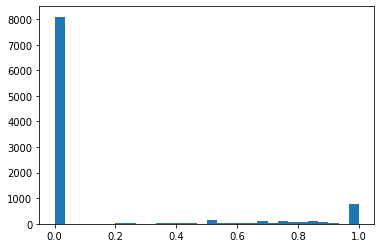

In [164]:
plt.hist(frac_ipv6_influencers, bins=30)

In [148]:
cascade_sizes = []
cascade_depths = []
cascade_size_dict = {}
cascade_depth_dict = {}
for node in ipv6_nodes:
    cascade_size = calculate_cascade_size(node, set())
    cascade_depth = calculate_cascade_depth(node, 0, set())
    cascade_depths.append(cascade_depth)
#     print(node, cascade_depth, cascade_size)
    cascade_sizes.append(cascade_size)
    cascade_size_dict[cascade_size] = node
    cascade_depth_dict[cascade_depth] = node
# initial_node = random.choice(ipv6_nodes)
# print(initial_node)

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline


(array([7.337e+03, 1.680e+02, 7.000e+00, 0.000e+00, 4.000e+02, 4.800e+01,
        4.000e+02, 9.480e+02, 3.710e+02, 8.400e+01, 3.100e+01, 2.000e+01,
        2.500e+01, 1.700e+01, 1.500e+01, 1.000e+00, 4.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.0000e+00, 4.1300e+01, 8.1600e+01, 1.2190e+02, 1.6220e+02,
        2.0250e+02, 2.4280e+02, 2.8310e+02, 3.2340e+02, 3.6370e+02,
        4.0400e+02, 4.4430e+02, 4.8460e+02, 5.2490e+02, 5.6520e+02,
        6.0550e+02, 6.4580e+02, 6.8610e+02, 7.2640e+02, 7.6670e+02,
        8.0700e+02, 8.4730e+02, 8.8760e+02, 9.2790e+02, 9.6820e+02,
        1.0085e+03, 1.0488e+03, 1.0891e+03, 1.1294e+03, 1.1697e+03,
        1.2100e+03]),
 <a list of 30 Patch objects>)

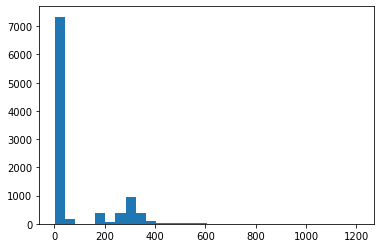

In [151]:
plt.hist(cascade_sizes, bins=30) 

(array([6.529e+03, 0.000e+00, 0.000e+00, 5.790e+02, 0.000e+00, 0.000e+00,
        1.620e+02, 0.000e+00, 0.000e+00, 0.000e+00, 2.800e+01, 0.000e+00,
        0.000e+00, 8.200e+01, 0.000e+00, 0.000e+00, 1.070e+02, 0.000e+00,
        0.000e+00, 0.000e+00, 1.851e+03, 0.000e+00, 0.000e+00, 4.270e+02,
        0.000e+00, 0.000e+00, 1.130e+02, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 1. ,  1.3,  1.6,  1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ,
         4.3,  4.6,  4.9,  5.2,  5.5,  5.8,  6.1,  6.4,  6.7,  7. ,  7.3,
         7.6,  7.9,  8.2,  8.5,  8.8,  9.1,  9.4,  9.7, 10. ]),
 <a list of 30 Patch objects>)

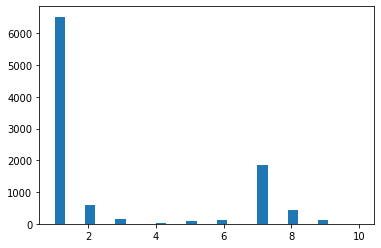

In [152]:
plt.hist(cascade_depths, bins=30) 

In [95]:
sorted(cascade_sizes, reverse=True)[0:10]

[1210, 758, 695, 691, 682, 675, 674, 670, 611, 600]

In [96]:
cascade_dict[1210]

6939

In [ ]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [145]:
calculate_cascade_depth(11537, 0, set())

0
10343
0
0
0
63056
6325
0
0
0
0
0
14
0
0
10497
0
46
0
0
0
0
112
0
0
0
0
0
0
0
0
0
0
1547
57111
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1140
34177
0
0
0
0
0
0
0
0
8632
59689
0
8403
0
0
0
3573
0
0
0
40773
0
0
0
0
0
53740
0
0
0
0
0
0
16019
0
0
0
0
0
15691
29504
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
204151
0
0
0
0
0
0
0
12850
0
6082
0
4181
0
0
13359
0
0
0
23728
0
0
0
0
48450
0
0
0
0
0
0
0
9198
41722
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
6775
12307
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
5563
60501
0
0
22845
0
27282
0
0
0
11096


9

In [143]:
root_node = 11537

c_G, labels = build_graph(root_node, set(), nx.DiGraph(), {})
# pos = hierarchy_pos(c_G,root_node)    
pos = nx.spring_layout(c_G)

fig = nx.draw(c_G)
plt.savefig("graph.pdf")


Error in callback <function flush_figures at 0x11d0f5840> (for post_execute):


KeyboardInterrupt: 

In [112]:
print(len(list(G.neighbors(10010))))

54


In [113]:
node = random.choice(ipv6_nodes)
print(node)
print(G.nodes[node])

63414
{'ipv6': True, 'time_adopted': 0}


In [114]:
for n in G.neighbors(node):
    print(G.nodes[n])

{'ipv6': True, 'time_adopted': 0}
{}


In [37]:
avg_fraction = 0
count = 0
for n in ipv6_nodes:
    node = G.nodes[n]
    if node['time_adopted'] > 0 and node['num_neighbors'] > 0:
        avg_fraction += float(node['ipv6_neighbors']) / node['num_neighbors']
        count += 1
print(avg_fraction/float(count))

0.7708165867754263


In [85]:
(3549, 1) in G.edges

True